# Table of Contents
- [Dynamic Time Patterns for Algorithmic Trading using machine learning](#dynamic-time-patterns-for-algorithmic-trading-using-machine-learning)
  - [Setup and Preprocessing](#setup-and-preprocessing)
  - [Math Behind the Algorithm](#math)
    - [Distance Metrics](#distance-metrics)  
    - [K Nearest Neighbor Algorithm](#k-nearest-neighbor-algorithm)
  - [Simple Backtest](#simple-backtest-of-forecast-predictions)
    - [Backtest Strategy](#backtest-strategy)
  - [Results and Visualization](#results-and-visualization)  
  - [Conclusion](#conclusion)

# Dynamic Time Patterns for Algorithmic Trading using machine learning

This project explores time series forecasting in algorithmic trading using KNN clustering with various distance metrics. The objective is to evaluate which metric achieves the highest accuracy in predicting volatility-adjusted returns using NMAE. Additionally, a simple backtesting strategy is implemented and assessed through financial metrics such as Sharpe ratio and maximum drawdown.


## Setup and Preprocessing
To run algorithm, import libraries, and initialize data. 

The time-interval used (1-month of data) and the parameters, make the algorithm/predictions take roughly 20 minutes.



### Enviornment Setup
Install the required libraries using:

In [10]:
pip install numpy pandas matplotlib fastdtw scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from sklearn.neighbors import NearestNeighbors

### Data Collection
For this project, high-frequency forex data has been used, soruced from Metatrader.

It is downloaded as 1 minute data, which is being changed to 5-minute intervals, where the Closing price of the asset will be used for the return. The data has the Time, Open, High, Low and Closing price.

In the case of the example of the algorithm, the GBP/USD data is used, with the time period March 1, 2021 00:00 to march 31, 2021 23:55.

In [12]:
df = pd.read_csv("gbp_usd_5min.csv", parse_dates=["Time"])

# Sort the index to ensure monotonicity
df.set_index("Time", inplace=True)
df = df.sort_index()

# date-range of data that will be used
start_date = "2021-03-01 00:00"
end_date = "2021-03-31 17:15"

# Define range of df to be used based on dates
df = df.loc[start_date:end_date]

print(df.tail())


                        Open     High      Low    Close
Time                                                   
2021-03-31 16:55:00  1.37838  1.37848  1.37788  1.37791
2021-03-31 17:00:00  1.37792  1.37816  1.37759  1.37809
2021-03-31 17:05:00  1.37808  1.37840  1.37787  1.37787
2021-03-31 17:10:00  1.37802  1.37802  1.37794  1.37795
2021-03-31 17:15:00  1.37795  1.37801  1.37794  1.37798


### data preprocessing

Checking for missing values:

In [13]:
print(df.isna().sum())


Open     0
High     0
Low      0
Close    0
dtype: int64


Logarithmic returns are computed based on closing price at time $t$ divided by closing price at time $t+1$.

In [14]:
df["returns"] = np.log(df["Close"] / df["Close"].shift(1))
df.dropna(inplace=True)

#### Smoothing Returns Using Exponential Moving Average

The returns are smoothed using exponential moving average.
The Exponential Moving Average (EMA) is a weighted moving average that gives more significance to recent data points, making it more responsive to price changes compared to a simple moving average (SMA). 

##### Formula:
$
EMA_t = \alpha \cdot R_t + (1 - \alpha) \cdot EMA_{t-1}
$

where:
- $ EMA_t $ is the exponential moving average at time $ t $,
- $ R_t $ is the return at time \( t \),
- $ \alpha $ is the smoothing factor, calculated as:
  $
  \alpha = \frac{2}{span + 1}
  $
- $ span $ is the chosen period for smoothing.

The smoothing factor $ \alpha $ determines how much weight recent returns receive. A higher $ \alpha $ (lower span) makes the EMA react more to new data, while a lower $ \alpha $ (higher span) results in a smoother curve. [1]

The implementation in python is as followed:

In [15]:
def apply_ema(series, span):
    return series.ewm(span=span, adjust=False).mean()

df["ema_returns"] = apply_ema(df["returns"], span=15)
df.dropna(inplace=True)
print(df["ema_returns"].head())

Time
2021-03-01 00:05:00    0.000007
2021-03-01 00:10:00    0.000052
2021-03-01 00:15:00    0.000035
2021-03-01 00:20:00    0.000022
2021-03-01 00:25:00    0.000031
Name: ema_returns, dtype: float64


To validate the function’s correctness (and to show the formula calculation in python), the EMA of return 100 is calculated and compared to the output from apply_ema():

In [16]:
span = 15
EMA_return_100 = 2/(span+1) * df["returns"].iloc[100] + (1 - 2/(span+1)) * df["ema_returns"].iloc[99]
if EMA_return_100 == df.iloc[100]["ema_returns"]:
    print("🎉🎉🎉")
print("Manual EMA:", EMA_return_100)
print("apply_ema() EMA:", df["ema_returns"].iloc[100])

🎉🎉🎉
Manual EMA: -0.00019552803368233756
apply_ema() EMA: -0.00019552803368233756


#### Standardizing EMA Returns Using Rolling Standard Deviation
Standardization is used to normalize data by adjusting for variations in scale and volatility, making it easier to compare values across different time, allowing the detection of regime shifts.

$
\sigma_t = \sqrt{\frac{1}{w} \sum_{i=t-w+1}^{t} (EMA_i - \bar{EMA})^2}
$

where:

- $ \sigma_t $ is the rolling standard deviation at time $ t $,
- $ EMA_i $ are the exponential moving averages within the window,
- $ \bar{EMA} $ is the mean EMA within the window,
- $ w $ is the window size.

standardize the EMA returns:

$
EMA_{std,t} = \frac{EMA_t}{\sigma_t}
$

In this case the window is 120.

The implementation in python is as followed:

In [17]:
window_size = 120
df["rolling_std"] = df["ema_returns"].rolling(window=window_size, min_periods=1).std()
df["rolling_std"] = df["rolling_std"].fillna(df["rolling_std"].mean())
df["ema_returns_std"] = df["ema_returns"] / df["rolling_std"]
df.dropna(inplace=True)


In [18]:
print(df["ema_returns_std"].max())
print(df["ema_returns_std"].min())
print(df["ema_returns"].max())
print(df["ema_returns"].min())

5.335501904526235
-5.087566660043141
0.00045468557104647077
-0.00039797512389973385


Volatility-adjusted, Standardized EMA returns roughly range between ±5.

Non-standardized EMA returns are approximately between ±0.0004, which is very low in magnitude.

## Algorithm and Mathematical Foundation

The core of this project is a k-Nearest Neighbors (kNN) model applied to time series forecasting. By identifying the closest historical patterns, one can predict future returns

These predictions accuracy will be assessed using NMAE, comparing the different distance metrics used in KNN.

### Introduction to K-Nearest-Neighbor Algorithm

KNN algorithm is commonly used for classifying data points, but can also be applied to time series forecasting by identifying the most similar past sequences.

KNN works by directly comparing a new data point to historical examples, finding the k most similar instances (neighbors) based on a distance metric, such as Euclidean distance.

Imagine a brokerage firm wants to predict if a new investor is likely to sell their shares of Apple (AAPL) within the next month based on their trading history. They use KNN by looking at a dataset of past investors, where each is represented by a vector of the features: Number of trades in pas 30 days, average holding period, and portfolio size. For a new investor with 5 trades, a 10-day average hold, and a \$10,000 portfolio, KNN finds the 5 most similar past investors. If three of those sold AAPL within a month, the algorithm predicts this new investor is likely to dump their shares too.

In this case, KNN doesn’t rely on clusters or predefined groups—it’s all about proximity in the feature space. The choice of k (here, 5) balances between overfitting (too small a k) and smoothing out patterns (too large a k).



#### K-Means Clustering
A different algorithm, but very much alike, is the K-Means Algorithm. Instead of using a datapoint, finding nearest datapoints, quantifying a classification, centroid will be randomly placed, clustering the data.

A use case of this is Economic Segmentation:
A central bank wants to classify countries based on their economic stability to guide monetary policy decisions. It collects data on:

- GDP Growth Rate (%)

- Inflation Rate (%)

- Unemployment Rate (%)

- Foreign Exchange Reserves (in billion USD)

Using K-Means, the algorithm clusters countries into three economic categories:

1. Stable Economies – Low inflation, steady GDP growth, low unemployment, and high reserves.

2. Emerging Markets – High GDP growth but moderate inflation and unemployment, with moderate forex reserves.

3. Struggling Economies – High unemployment, high inflation, slow GDP growth, and low reserves.

This clustering helps policymakers adjust interest rates, set exchange rate policies, or provide financial aid to struggling economies.

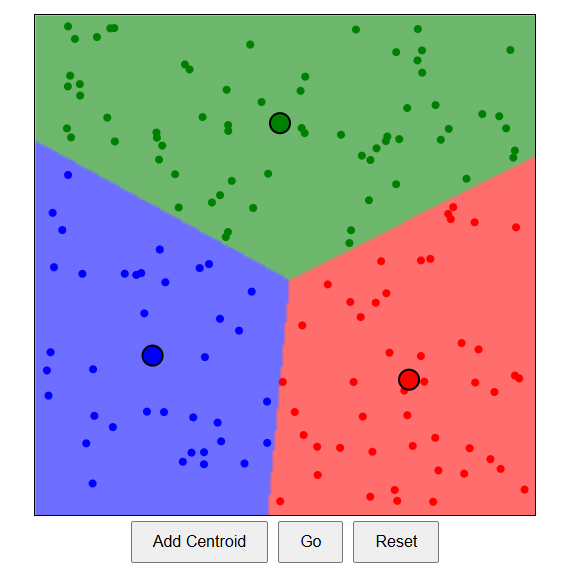

The image above is taken from my project @ https://kristofferjoha.github.io/ClusteringAlgos/, which visualizes the k-means algorithm. (can be slow due to grid resolution)

After having placed centroids, it iterates over the distances and clusters the datapoint, aiming for the shortest avg. distance to each datapoint.

To reference back to K-Nearest-Neighbour, if one imagines that the centroids (black outline) are datapoints in the KNN algorithm. You find the k-nearest datapoints and find the avg. value of what you are trying to predict. In the case of this algorithm, Dynamic Time Patterns, it would be Standardized EMA returns.

### Distance Metrics for Time Series Forecasting with kNN
When using k-Nearest Neighbors (kNN) for time series forecasting, the choice of distance metric is crucial. Since time series data contains temporal dependencies, standard measures like Euclidean distance may not always be effective.

Below are four commonly used distance metrics for comparing time series in forecasting models:

- Euclidean distance

- Dynamic Time Warping (DTW)

- Average Squared Distance (ASD)

- Complexity-Invariant Distance (CID) 

Euclidean distance is the simplest and most commonly used, but more advanced metrics like DTW are better suited when time series exhibit shifts in timing or volatility. [2]

#### Euclidean distance

Euclidean measures the straight-line distance between two sequences of equal length, summing up the squared differences between corresponding points. [3]

##### Formula

Given two time series: $ X=(x_1, x_2, ...,x_n ) $ and $ =(y_1, y_2, ...,y_n)$, the distance between the two time series is:

$D(X, Y) = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}$

- $x_i$ and $y_i$ are the values of the time series at the i-th element
- n is length of time series

This is a fairly simple formula and can be implemented in python the following way:

In [8]:
import numpy as np

# Defining two series
X = np.array([3,4,5,6])
Y = np.array([6,5,4,3])
X_easy = np.array([1, 2])
Y_easy = np.array([4, 6])

# Eucledean Distance
distance = np.sqrt(np.sum((X - Y)**2))
distance_easy = np.sqrt(np.sum((X_easy - Y_easy)**2))

print("Euclidean Distance:", distance)
print("Euclidean Distance Pythagoras:", distance_easy)


Euclidean Distance: 4.47213595499958
Euclidean Distance Pythagoras: 5.0


The "Pythagoras" example is included because it is easy to relate to. The distance between the points P(1,2) and P(4,6) is 5, based on the Pythagorean theorem where side lengths 3 and 4 give a hypotenuse length of 5.

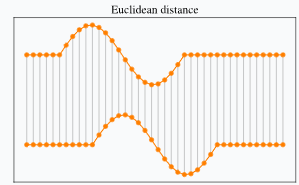

The picture from [4] shows euclidean distance for a time series. It compares each element with the corresponding value. The important thing here is that, as mentioned, the length of the two series must be equal.

#### Dynamic Time Warping (DTW)
DTW is a more flexible measure of distance between two time series, especially when they may be out of phase or have varying lengths. Unlike Euclidean distance, which assumes that the corresponding points in two sequences match up directly, DTW allows for the alignment of time series in a non-linear fashion.

DTW computes the minimum cumulative distance between two sequences by "warping" them to align the most similar points. This is done by comparing each element of one series with several elements of the other series, allowing for shifting, stretching, and compressing the time axis.

DTW has some steps to it [5]:

- Step 1: Distance Matrix construction
Use euclidean or other metric to construct a distance matrix between the two sequences.

$D(i,j)=dist(x_i,y_j)$

$$
D= \begin{pmatrix}
  dist(x_1,y_1) & dist(x_1,y_2) & ... & dist(x_1,y_m) \\
  dist(x_2,y_1) & dist(x_2,y_2) & ... & dist(x_2,y_m) \\
  \vdots & \vdots & \ddots & \vdots \\
  dist(x_n,y_1) & dist(x_n,y_2) & ... & dist(x_n,y_m)
\end{pmatrix}
$$

- Step 2: Cumulative Cost Matrix
Next step is to calculate the cumulative cost matrix, which keeps track of the minimum cumulative distance at each point, considering all previous points in both sequences

Based on the distance matrix D, the cost for each point (i,j) is the $x_i $ and $y_j$ distance, plus the minimum cumulative distance from previous step.

The recursive formula is as followed:

$D(i,j)=dist(x_i,y_j) + min(C(i-1,j),C(i,j-1),C(i-1,j-1))$

- $C(i-1,j)$ represents vertical movement
- $C(i,j-1)$ represents horizontal movement
- $C(i-1,j-1)$ represents diagonal movement


$$
C= \begin{pmatrix}
  C(1,1) & C(1,2) & ... & C(1,m) \\
  C(2,1) & C(2,2) & ... & C(2,m) \\
  \vdots & \vdots & \ddots & \vdots \\
  C(n,1) & C(n,2) & ... & C(n,m)
\end{pmatrix}
$$

The value for $(n,m)$ gives total comulative distance between two time series with best alignment.

- Step 3: path finding

With the comulative cost matrix C, it is time to find the optimal warping path. This means finding the path from C(n,m) to C(1,1) by following the minimum values.

This is done by moving one step at a vertically, horizontally, or diagonally based on minimum cost.

- Step 4: DTW Distance Calculation

The DTW distance is that which gives the minimum comulative cost to align the two time series.

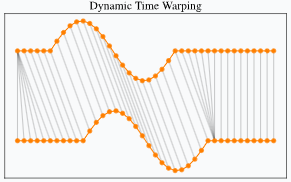

The picture from [4] shows Dynamic type warping distance for a time series. Two time series with different length are being compressed and streched to fit optimally with one another.

fastdtw, an approximate Dynamic Time Warping algorithm, will be used for the dynamic time warping for this project.



#### Average Squared Distance (ASD) 
The ASD is similar to Euclidean distance, but instead of taking the square root of the sum of the squared differences, the sum of the squared differences is calculated and divided by the length of the time series.

##### Formula
Given two time series: $ X=(x_1, x_2, ...,x_n ) $ and $ =(y_1, y_2, ...,y_n)$, the distance between the two time series is:

$ASD(X, Y) = \frac{1}{n}\sum_{i=1}^{n} (x_i - y_i)^2$

- $x_i$ and $y_i$ are the values of the time series at the i-th element
- n is length of time series

This is also a fairly simple formula and can be implemented in python the following way:

In [9]:
import numpy as np

# Defining two series
X = np.array([3,4,5,6])
Y = np.array([6,5,4,3])

# ASD calculation
asd = np.mean((X - Y)**2)

print("Average Squared Distance:", asd)

Average Squared Distance: 5.0


Given the same two series as in the euclidean distance, it can be seen that the results differ. Outliers are more impactful in ASD.

#### Complexity-Invariant Distance



### KNN implementation

In [ ]:
def dtw_metric(x, y):
    distance, _ = fastdtw(x, y)
    return distance

def cid_metric(x, y):
    ce_x = np.sqrt(np.sum(np.diff(x) ** 2))
    ce_y = np.sqrt(np.sum(np.diff(y) ** 2))
    base_dist = np.sqrt(np.sum((x - y) ** 2))
    cf = max(ce_x, ce_y) / min(ce_x, ce_y) if min(ce_x, ce_y) > 0 else 1.0
    return base_dist * cf 

def asd_metric(x, y):
    return np.mean((x - y) ** 2) if len(x) == len(y) else float('inf')

In [ ]:
def knn_forecast(series, window_size=240, embed_size=15, k=20, metric=asd_metric):
    predictions = []
    for i in range(window_size + embed_size, len(series)):
        query = series.iloc[i - embed_size:i].values
        history = series.iloc[:i - embed_size].values
        if len(history) < window_size:
            predictions.append(0)
            continue
        start_index = max(0, len(history) - window_size)
        historical_embeddings = np.array([
            history[j:j + embed_size] for j in range(start_index, len(history) - embed_size + 1)
        ])
        nbrs = NearestNeighbors(n_neighbors=k, metric=metric, n_jobs=-1)
        nbrs.fit(historical_embeddings)
        dist, indices = nbrs.kneighbors([query])
        next_returns = [series.iloc[start_index + idx + embed_size] for idx in indices[0]]
        weights = 1 / (dist[0] + 1e-6)
        prediction = np.average(next_returns, weights=weights)
        predictions.append(prediction)
    return [0] * (window_size + embed_size) + predictions 
df["knn_asd_pred"] = knn_forecast(df["ema_returns_std"], metric=asd_metric)
df["knn_cid_pred"] = knn_forecast(df["ema_returns_std"], metric=cid_metric)
df["knn_dtw_pred"] = knn_forecast(df["ema_returns_std"], metric=dtw_metric)
df["knn_euc_pred"] = knn_forecast(df["ema_returns_std"], metric="euclidean")

#### Algorithm results

## Simple Backtest of Forecast Predictions

### Backtest Strategy

## Results and Visualization

## Conclusion

## References
[1] James Chen. (2024). [What is EMA? How to Use Exponential Moving Average With Formula](https://www.investopedia.com/terms/e/ema.asp)

[2] G. E. A. P. A. Batista, X. Wang, and E. J. Keogh, "A Complexity-Invariant Distance Measure for Time Series,"

[1] GeeksForGeeks (2023). [Similarity Search for Time-Series Data](https://www.geeksforgeeks.org/similarity-search-for-time-series-data/)


[4] Romain Tavenard [An introduction to Dynamic Time Warping](https://rtavenar.github.io/blog/dtw.html)

[5] GeeksForGeeks (2024). [Dynamic Time Warping (DTW) in Time Series](https://www.geeksforgeeks.org/dynamic-time-warping-dtw-in-time-series/)